# Analyse de Sentiment avec BERT
Ce notebook utilise un petit échantillon du jeu de données pour réduire le temps d'entraînement.


## Installation des dépendances
Nous installons ici les bibliothèques nécessaires.

In [ ]:
# Installation des paquets Python
!pip install transformers==4.30.0  # Fixes tokenizers installation
!pip install datasets scikit-learn matplotlib
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 676.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.30.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Importation des bibliothèques

In [ ]:
# Importation des modules nécessaires
from collections import defaultdict


## Initialisation du modèle BERT pour la classification

In [ ]:
# Importation des modules nécessaires
from transformers import BertTokenizer, BertForSequenceClassification
print("✅ Transformers est bien installé !")

✅ Transformers est bien installé !


## Création des DataLoaders

## Configuration de l'optimiseur et du scheduler

In [ ]:
# Importation des modules nécessaires
import transformers
from transformers import BertModel, BertTokenizer, get_scheduler
from torch.optim import AdamW
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Configure matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Set Seaborn style (remove 'palette' to avoid conflicts)
sns.set(style='whitegrid', font_scale=1.2)

# Define and set custom palette
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(HAPPY_COLORS_PALETTE)  # Global palette

# Figure size
rcParams['figure.figsize'] = (4, 4)

# Random seeds and device (unchanged)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Code
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 44.4MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 43.8MB/s]


In [ ]:
# Chargement du dataset depuis un fichier CSV
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [ ]:
# Code
df.shape

(15746, 11)

In [ ]:
# Code
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


## Visualisation des scores de critique

<ipython-input-9-75a48c5d3f73>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=df, palette=HAPPY_COLORS_PALETTE)
<ipython-input-9-75a48c5d3f73>:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.countplot(x='score', data=df, palette=HAPPY_COLORS_PALETTE)


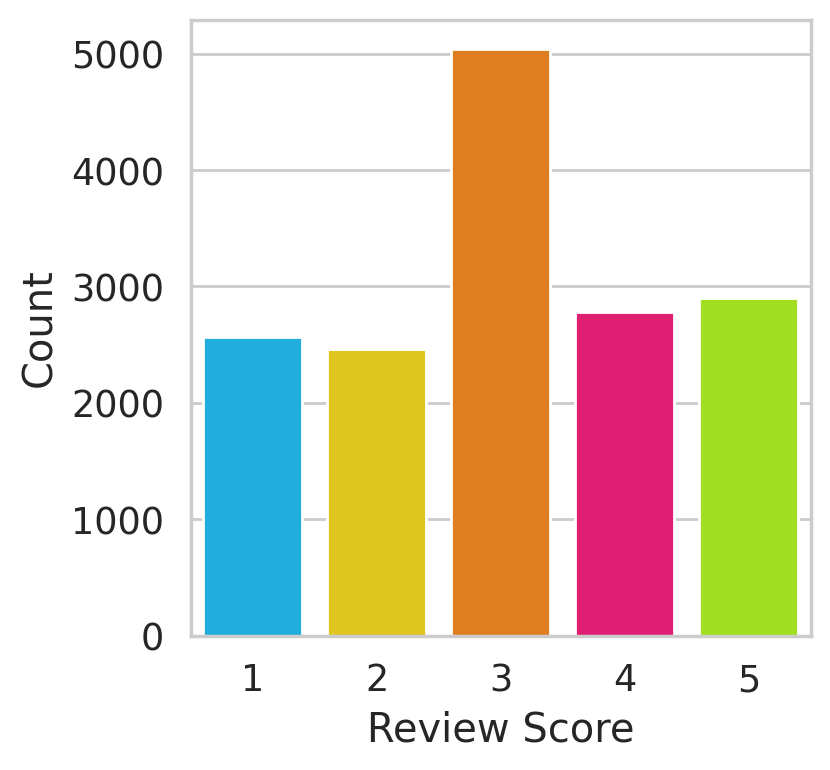

In [ ]:
# Création d'un graphique de distribution des scores
# Plot counts (raw numbers)
sns.countplot(x='score', data=df, palette=HAPPY_COLORS_PALETTE)
plt.ylabel('Count')  # Match tutorial's "Count" label
plt.xlabel('Review Score')
plt.show()

## Préparation des labels de sentiment

In [ ]:
# Fonction pour convertir les notes en classes de sentiment
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

In [ ]:
# Code
df['sentiment'] = df.score.apply(to_sentiment)


In [ ]:
# Code
class_names = ['negative', 'neutral', 'positive']


## Visualisation des scores de critique

<ipython-input-13-489d9cffc9ca>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)  # Étiquettes personnalisées


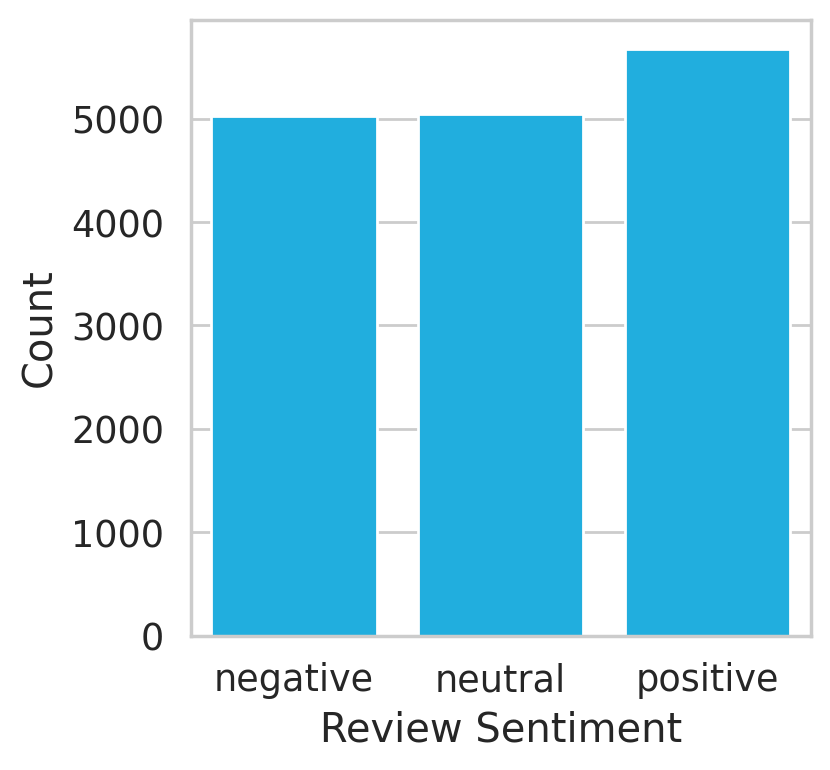

In [ ]:
# Création d'un graphique de distribution des scores
# Configuration du style
sns.set(style='whitegrid', font_scale=1.2)
sns.set_palette(HAPPY_COLORS_PALETTE)

# Tracer les comptes
plt.figure(figsize=(4, 4))
ax = sns.countplot(x='sentiment', data=df)
plt.xlabel('Review Sentiment')
plt.ylabel('Count')
ax.set_xticklabels(class_names)  # Étiquettes personnalisées
plt.show()

In [ ]:
# Code
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'


In [ ]:
# Chargement du tokenizer et du modèle BERT
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Code
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
# Code
tokens = tokenizer.tokenize(sample_txt)


In [ ]:
# Code
print(tokens)

['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']


In [ ]:
# Code
token_ids = tokenizer.convert_tokens_to_ids(tokens)


In [ ]:
# Code
print(token_ids)


[1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
# Code
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
# Code
tokenizer.cls_token, tokenizer.cls_token_id


('[CLS]', 101)

In [ ]:
# Code
tokenizer.pad_token, tokenizer.pad_token_id


('[PAD]', 0)

In [ ]:
# Code
tokenizer.unk_token, tokenizer.unk_token_id


('[UNK]', 100)

In [ ]:
# Code
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
# Code
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
# Code
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
# Code
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])


['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

## **Choosing Sequence Length**

In [ ]:
# Code
token_lens = []
for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

<ipython-input-31-e26792e2e310>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


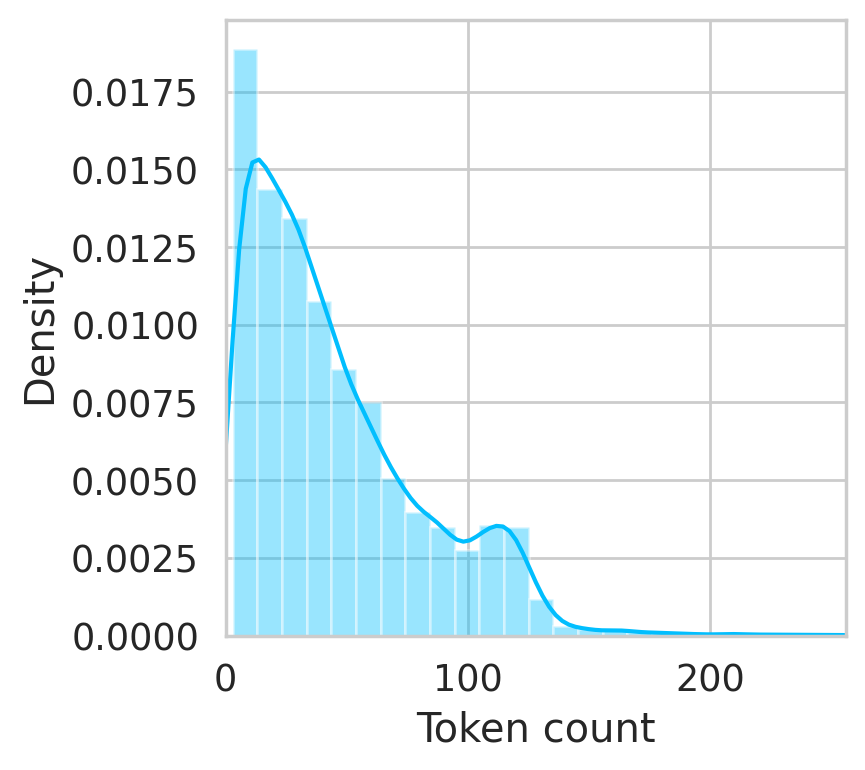

In [ ]:
# Code
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
# Code
MAX_LEN = 64

In [ ]:
# Code
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# Code
# Reduce dataset size to ~8000 samples (faster training)
df_small = df.sample(n=500, random_state=RANDOM_SEED)

# Split into train/val/test
df_train, df_test = train_test_split(
    df_small,
    test_size=0.1,
    random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=RANDOM_SEED
)


## Création des DataLoaders

In [ ]:
# Préparation des DataLoaders pour PyTorch
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )
BATCH_SIZE = 16
num_workers=2
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Code
data = next(iter(train_data_loader))
print(data.keys())  # <-- Only this line is needed
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 64])
torch.Size([16, 64])
torch.Size([16])


torch.Size([16])

# **Sentiment Classification with BERT and Hugging Face**


In [ ]:
# Code
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Code
output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

last_hidden_state = output.last_hidden_state
pooled_output = output.pooler_output

print("Last hidden state shape:", last_hidden_state.shape)
print("Pooled output shape:", pooled_output.shape)


Last hidden state shape: torch.Size([1, 32, 768])
Pooled output shape: torch.Size([1, 768])


In [ ]:
# Code
last_hidden_state.shape
torch.Size([1, 32, 768])

torch.Size([1, 32, 768])

In [ ]:
# Code
bert_model.config.hidden_size


768

In [ ]:
# Code
pooled_output.shape


torch.Size([1, 768])

In [ ]:
# Code
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)  # Fixed spelling
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        return self.out(outputs.pooler_output)

In [ ]:
# Code
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Code
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 64])
torch.Size([16, 64])


In [ ]:
# Importation des modules nécessaires
import torch.nn.functional as F
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2691, 0.3089, 0.4220],
        [0.2734, 0.3056, 0.4209],
        [0.2434, 0.3379, 0.4187],
        [0.2887, 0.2604, 0.4509],
        [0.2537, 0.3316, 0.4147],
        [0.3002, 0.2548, 0.4450],
        [0.2662, 0.2918, 0.4421],
        [0.2735, 0.2915, 0.4350],
        [0.2779, 0.2865, 0.4355],
        [0.2701, 0.3055, 0.4243],
        [0.2641, 0.3083, 0.4276],
        [0.2751, 0.2985, 0.4264],
        [0.2635, 0.3116, 0.4249],
        [0.2914, 0.2876, 0.4210],
        [0.2807, 0.2965, 0.4228],
        [0.2594, 0.3149, 0.4257]], grad_fn=<SoftmaxBackward0>)

**Training**

In [ ]:
# Importation des modules nécessaires
from transformers import get_linear_schedule_with_warmup


## Configuration de l'optimiseur et du scheduler

In [ ]:
# Configuration de l'optimiseur et du planificateur de taux d'apprentissage
EPOCHS = 2
total_steps = len(train_data_loader) * EPOCHS
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

## Configuration de l'optimiseur et du scheduler

In [ ]:
# Configuration de l'optimiseur et du planificateur de taux d'apprentissage
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

## Évaluation du modèle

In [ ]:
# Passage en mode évaluation sans calcul de gradients
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

## Configuration de l'optimiseur et du scheduler

## Boucle d'entraînement

In [ ]:
# Importation des modules nécessaires
from collections import defaultdict

# Initialize history
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Train epoch with all required parameters
    train_acc, train_loss = train_epoch(
        model=model,
        data_loader=train_data_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        scheduler=scheduler,
        n_examples=len(df_train)
    )

    # Validation with required parameters
    val_acc, val_loss = eval_model(
        model=model,
        data_loader=val_data_loader,
        loss_fn=loss_fn,
        device=device,
        n_examples=len(df_val)
    )

    # Track metrics
    history['train_acc'].append(train_acc.cpu().item())
    history['val_acc'].append(val_acc.cpu().item())
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')
    print(f'Val loss {val_loss:.4f} accuracy {val_acc:.4f}\n')

Epoch 1/2
----------


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 1.0812 accuracy 0.4156
Val loss 1.0625 accuracy 0.4800

Epoch 2/2
----------


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.9809 accuracy 0.6556
Val loss 1.0705 accuracy 0.3600



## Courbe d'entraînement

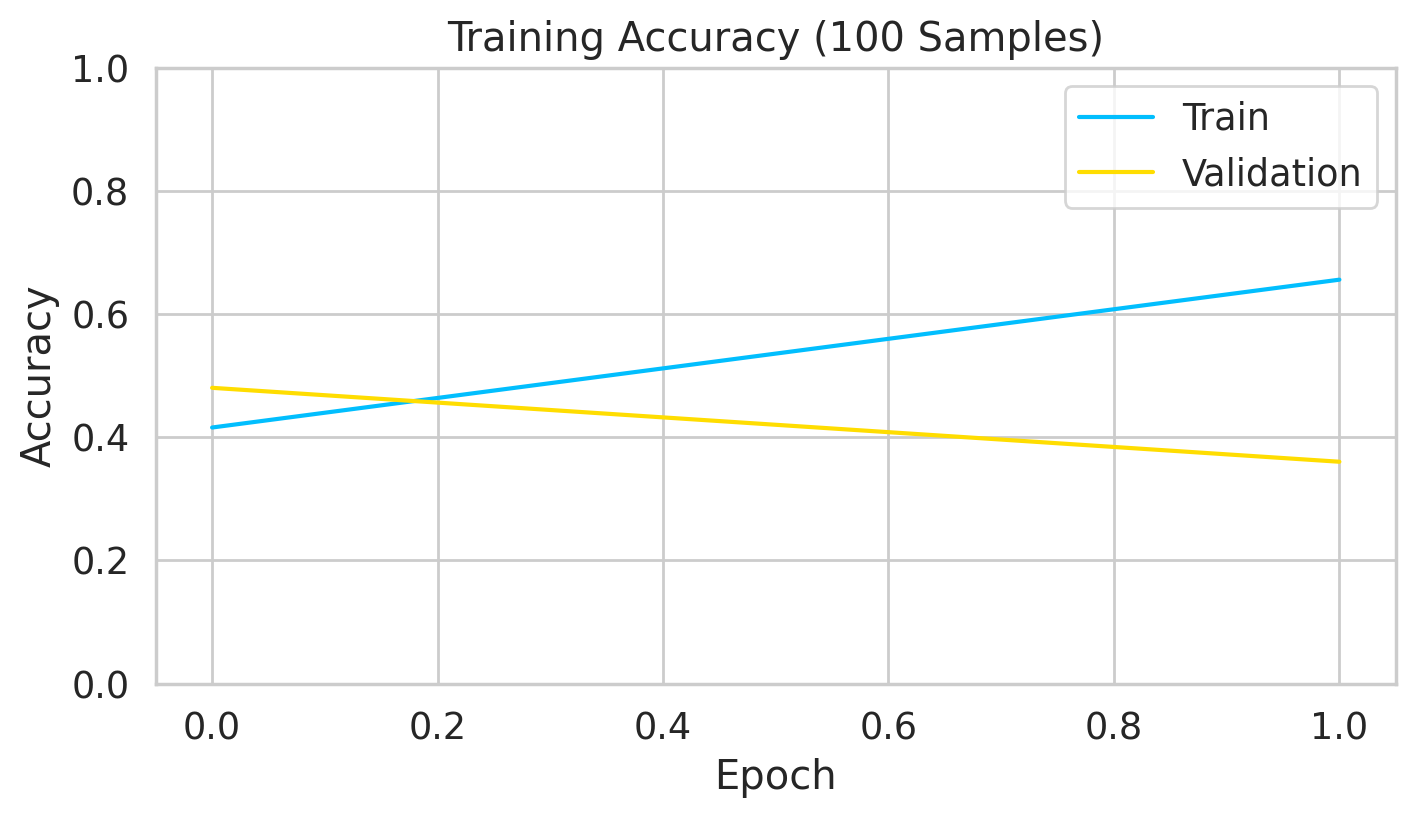

In [ ]:
# Affichage de la courbe de perte au fil des epochs
# Add these imports at the top if missing
import matplotlib.pyplot as plt
%matplotlib inline

# Then add this AFTER training completes
if 'history' in locals():
    plt.figure(figsize=(8, 4))
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Training Accuracy (100 Samples)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim(0, 1)
    plt.show()
else:
    print("No history found - check training execution")

# **Evaluation**

In [ ]:
# Code
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

0.52

## Évaluation du modèle

In [ ]:
# Passage en mode évaluation sans calcul de gradients
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
# Code
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [ ]:
# Code
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    negative       0.65      0.79      0.71        14
     neutral       0.00      0.00      0.00         6
    positive       0.25      0.40      0.31         5

    accuracy                           0.52        25
   macro avg       0.30      0.40      0.34        25
weighted avg       0.41      0.52      0.46        25



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


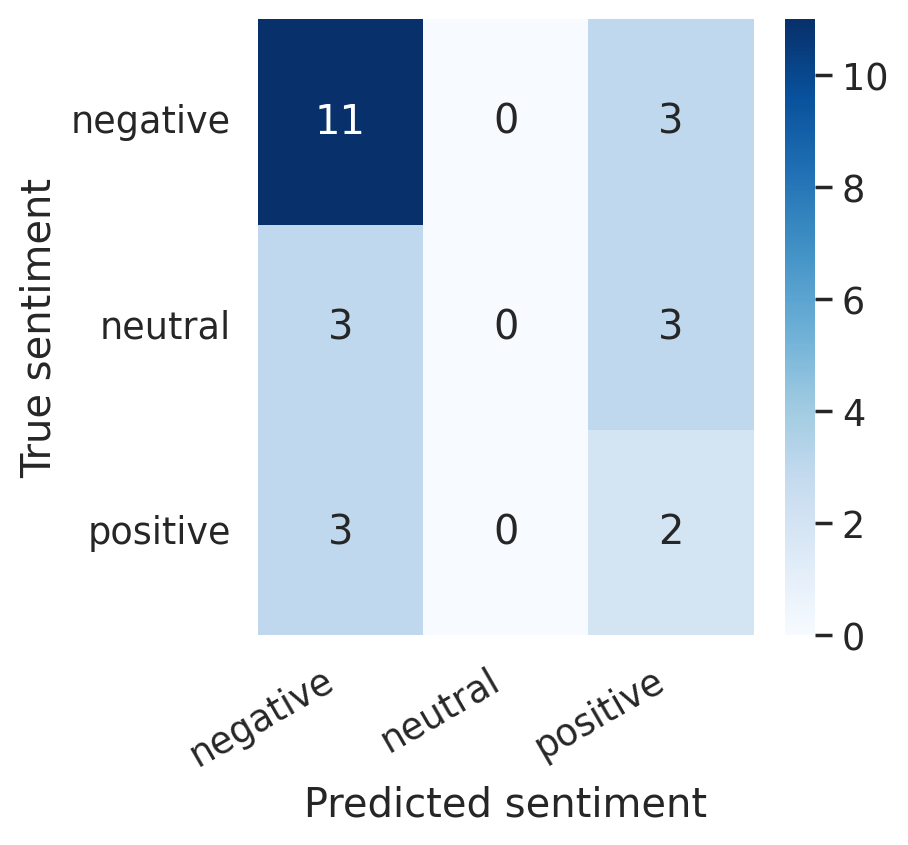

In [ ]:
# Code
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
# Code
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

In [ ]:
# Code
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

NameError: name 'sns' is not defined

# **Predicting on Raw Text**


In [ ]:
# Code
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
# Code
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Code
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
